# AMOC in density coordinates for MPAS-Ocean CORE II runs

This notebook details a Python-based method for calculating AMOC in density coordinates in the MPAS-Ocean LR and HR Core II simulations.

#### Optimized edge interpolation

The method used in this notebook optimizes the interpolation of cell variables to edges by defining a `subdomainEdge` nested inside a `subdomainCell`. The interpolation-to-edge step requires that a new `cellsOnEdge` array be retrieved that specifically references cells on `subdomainCell`. The function `get_cellsOnEdge_subdomain` performs this task once and then saves the array to netCDF. This process takes about 15-20 min for the HR mesh, but the cost savings for processing the HR results are significant.

**Important Note:** The HR meshfiles in `/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/oRRS18to6v3/` have nonsense edge IDs in the fill value places in the `edgesOnCell` variable, which should be zero but are not. This notebook identifies these values by comparing `nCells` to `cellsOnEdge` at these edge IDs.

***

In [1]:
import numpy as np
import xarray as xr
import yaml
import sys
import os
from matplotlib import pyplot as plt, patches
from tqdm import tqdm
import fastjmd95 as jmd95

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

In [2]:
def build_bottom_mask():
    """Bottom mask code, currently unused
    """
    
    # Bottom mask
    edgelevel = np.broadcast_to(maxLevelCell[cells].values[:, None], (len(cells), 7)).ravel()
    shape = (len(edges), len(nVertLevels))
    index2D = np.broadcast_to(nVertLevels[None, :], shape) < edgelevel[:, None]


def remap2edge(variable, cellsOnEdge):
    """Remap variable to edge by averaging cells on either side
    """
    
    # Remap to edge by averaging cells on either side
    neighbors = [variable[col, :] for col in cellsOnEdge.T]
    variable_remapped = (neighbors[0] + neighbors[1]) / 2
    
    return variable_remapped


def build_subdomain(lons, lats, bbox, buf=0):
    """
    """
    
    # Build subdomain
    subdomain, = np.where((lons>bbox[0]-buf) & (lons<bbox[1]+buf) & (lats>bbox[2]-buf) & (lats<bbox[3]+buf))
    
    return subdomain


def get_region_edges(regionCellMask, cellsOnEdge):
    """
    Get open water edges of an MPAS-Ocean masked region.
    """
    
    # Exclude land edges
    dropEdges = np.any(cellsOnEdge == -1, axis=1)
    
    # Exclude water edges that don't straddle the regionCellMask boundary (e.g. 0 neigboring 1)
    regionCellMaskNeighbors = [regionCellMask[cellsOnEdge[~dropEdges, col]] for col in (0, 1)]
    dropEdges[~dropEdges] = np.equal(*regionCellMaskNeighbors)
    
    # Find open boundary edges and signs (positive INTO region)
    openBoundaryEdges, = np.where(~dropEdges)
    openBoundarySigns = np.sign((regionCellMask[cellsOnEdge[~dropEdges, 1]] - 0.5))
    
    return openBoundaryEdges, openBoundarySigns


def get_cellsOnEdge_subdomain(
    coords, savepath,
    history_url='https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/notebooks/AMOC.ipynb',
):
    """Find cellsOnEdge on subdomain
    """
    
    # Find cellsOnEdge on subdomain
    cells, subdomain = [coords[name] for name in ('cellsOnEdge', 'subdomainCell')]
    subdomain_cellsOnEdge = np.array([np.where(np.isin(subdomain, pair, kind='sort'))[0] for pair in tqdm(cells)])

    # Save to netCDF out
    ds_attrs = {'history': history_url}
    var_attrs = {'long_name': 'List of cells in subdomainCell that border each edge in subdomainEdge'}
    ds = xr.Dataset({'subdomain_cellsOnEdge': (['nEdges', 'TWO'], subdomain_cellsOnEdge, var_attrs)}, attrs=ds_attrs)
    ds.to_netcdf(savepath)


def get_edge_signs(nCells, cellsOnEdge, edgesOnCell):
    """
    """
    
    # Build edge signs
    isNegative = cellsOnEdge[edgesOnCell, 0] == nCells
    edgeSignOnCell = np.where(isNegative, -1, 1)
    
    return edgeSignOnCell


def load_mesh_variables(meshfile, maskfile):
    """Load mesh variables
    """
    
    # Get region mask
    ds = xr.open_dataset(maskfile)
    regionMask = ds.regionCellMasks[:, 0].values.astype(bool)
        
    # Get mesk variables
    ds = xr.open_dataset(meshfile)

    # Get coordinate variables
    names = ['lonCell', 'latCell', 'lonEdge', 'latEdge']
    lonCell, latCell, lonEdge, latEdge = [np.rad2deg(ds[name].values) for name in names]
    lonCell, lonEdge = [np.where(var > 180, var - 360, var) for var in (lonCell, lonEdge)]
    #lon, lat = lonCell[regionMask], latCell[regionMask]
    #print(f'{lon.min():.2f}, {lon.max():.2f}, {lat.min():.2f}, {lat.max():.2f}')
    #return

    # Get dimension and index variables
    nCells = ds.nCells.values[:, None]
    shapeEdge = [ds.dims[dim] for dim in ('nEdges', 'nVertLevels')]
    cellsOnEdge, edgesOnCell = [ds[name].values - 1 for name in ('cellsOnEdge', 'edgesOnCell')]
    
    # Get dvEdge
    dvEdge = ds.dvEdge.values

    # Get edge signs on cell and build southern transect mask
    edgeSignOnCell = get_edge_signs(nCells, cellsOnEdge, edgesOnCell)
    edges, signs = get_region_edges(regionMask, cellsOnEdge)
    idx = latEdge[edges] < -30
    edges, signs = edges[idx], signs[idx]

    # Build subdomains
    bbox = [-98, 28, -35, 83]
    subdomainCell = build_subdomain(lonCell, latCell, bbox, buf=2)
    subdomainEdge = build_subdomain(lonEdge, latEdge, bbox, buf=0)
    subdomainEdge = subdomainEdge[np.all(cellsOnEdge[subdomainEdge, :] > 0, axis=1)]
    
    # Replace nonsense edge IDs with -1 in `edgesOnCell` (problem for HR meshfile)
    nCells, edgesOnCell = nCells[subdomainCell, :, None], edgesOnCell[subdomainCell, :]
    badEdges = np.all(cellsOnEdge[edgesOnCell, :] != nCells, axis=2)
    edgesOnCell[badEdges] = -1

    # Build output dict
    coords = {
        'zerosEdge': np.zeros(shapeEdge),
        'subdomainCell': subdomainCell,
        'subdomainEdge': subdomainEdge,
        'latCell': latCell[subdomainCell],
        'dvEdge': dvEdge[subdomainEdge, None],
        'cellsOnEdge': cellsOnEdge[subdomainEdge, :],
        'edgesOnCell': edgesOnCell,
        'edgeSignOnCell': edgeSignOnCell[subdomainCell, :],
        'regionMask': regionMask[subdomainCell],
        'transectMask': edges,
        'transectSigns': signs[:, None],
    }
    
    return coords

***

### Run the code

Get coordinates and subdomains

In [3]:
meshName = 'LR'

# Constants
rho0 = 1026.0     # Seawater density constant [kg m-3]
cpsw = 3.996e3    # Heat capacity of seawater [J kg-1 K-1]

# Latitude bins
binsize = 1
latbins = np.arange(-35, 83, binsize)

# Sigma bins
sigmaBins = np.arange(30, 38.01, 0.1)

# Variable names
prefix = 'timeMonthly_avg_'
namesCell = ['layerThickness', 'potentialDensity']
namesEdge = ['normalVelocity']

# Build results prefix
meshfile = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
maskfile = '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_AtlanticMask20250626.nc'
resultsprefix = '/pscratch/sd/b/bmoorema/run_001_062/20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly'
#meshfile = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3.171116.nc'
#maskfile = '/pscratch/sd/b/bmoorema/maskfiles/oRRS18to6v3_AtlanticMask20250627.nc'
#resultsprefix = '/global/cfs/cdirs/m4259/lvroekel/run_051_060/20210421_sim7_CORE_18to6v3.mpaso.hist.am.timeSeriesStatsMonthly'

# Get coords
coords = load_mesh_variables(meshfile, maskfile)

# Load subdomain_cellsOnEdge, or build the file if non-existent
filename = f'/pscratch/sd/b/bmoorema/maskfiles/AMOC_{meshName}_subdomain_cellsOnEdge.nc'
if not os.path.isfile(filename):
    get_cellsOnEdge_subdomain(coords, filename)
ds = xr.open_dataset(filename)
subdomain_cellsOnEdge = ds.subdomain_cellsOnEdge.values

/tmp/ipykernel_629673/3170640497.py:101: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shapeEdge = [ds.dims[dim] for dim in ('nEdges', 'nVertLevels')]


In [4]:
# Loop through years and months
amoc = []
for year in tqdm(range(1, 64)):
    for month in range(1, 13) : #, desc=f'Processing year {year}'):

        # Open results file
        ds = xr.open_dataset(resultsprefix + f'.{year:04d}-{month:02d}-01.nc')

        # Load edge variables
        v = ds[f'{prefix}normalVelocity'][0, ...].values[coords['subdomainEdge'], :]
        h = ds[f'{prefix}layerThickness'][0, ...].values[coords['subdomainCell'], :]
        T = ds[f'{prefix}activeTracers_temperature'][0, ...].values[coords['subdomainCell'], :]
        S = ds[f'{prefix}activeTracers_salinity'][0, ...].values[coords['subdomainCell'], :]
        T[T == -1e34] = np.nan
        S[S == -1e34] = np.nan
        rho = jmd95.rho(S, T, 2000.)
        h = remap2edge(h, subdomain_cellsOnEdge)
        rho = remap2edge(rho, subdomain_cellsOnEdge)
        rho[np.isnan(rho)] = 0
        
        # Inflate edge variables back to full domain
        transport, sigma = np.copy(coords['zerosEdge']), np.copy(coords['zerosEdge'])
        transport[coords['subdomainEdge'], :] = v * h * coords['dvEdge']
        sigma[coords['subdomainEdge'], :] = rho - 1000
        
        # Calculate southern edge
        transportSouth = (transport[coords['transectMask'], :] * coords['transectSigns']).ravel()
        sigmaSouth = sigma[coords['transectMask'], :].ravel()
        amocSouth = np.histogram(sigmaSouth, bins=sigmaBins, weights=transportSouth)[0]
        
        # Loop through latitude bins
        amocInterior = []
        for latbin in latbins:
        
            # Get edge indices
            cells = (coords['latCell'] > latbin) & (coords['latCell'] < latbin + binsize) & coords['regionMask']
            edges, signs = [coords[name][cells, :].ravel() for name in ('edgesOnCell', 'edgeSignOnCell')]
            index = edges >= 0
            edges, signs = edges[index], signs[index, None]
        
            # Loop through heat transport components and sum
            transportInterior = (transport[edges, :] * signs).ravel()
            sigmaInterior = sigma[edges, :].ravel()
            binned = np.histogram(sigmaInterior, bins=sigmaBins, weights=transportInterior)[0]
            amocInterior.append(binned)
        
        # Calculate full AMOC
        amocTotal = -amocSouth[None, :] + np.cumsum(amocInterior, axis=0)
        amoc.append(np.cumsum(amocTotal[:, ::-1], axis=1)[:, ::-1].T * 1e-6)

100%|██████████| 63/63 [30:21<00:00, 28.91s/it]


In [11]:
amoc_mean = np.mean(amoc, axis=0)

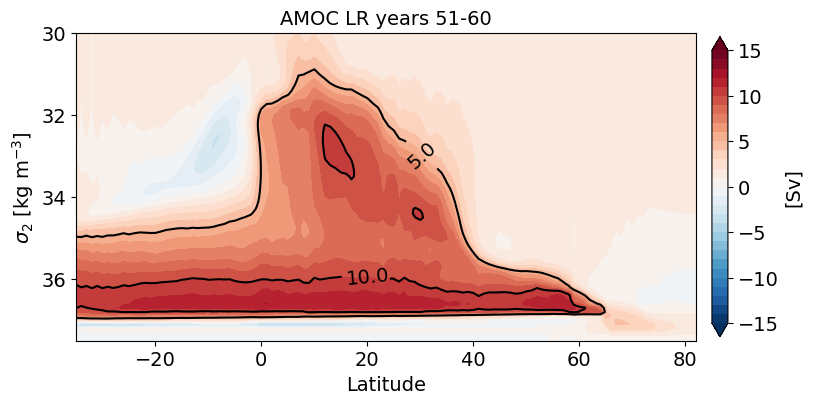

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
levels = np.arange(12, dtype=int)
levels = np.concatenate([-levels[::-1][:-1], levels])
c = ax.contourf(latbins, sigmaBins[:-1], amoc_mean, levels=np.arange(-15, 15.01, 1), cmap='RdBu_r', extend='both')
cs = ax.contour(latbins, sigmaBins[:-1], amoc_mean, levels=[5, 10], colors='k')
ax.clabel(cs, manual=[(30, 33), (20, 36)], fmt='%.1f', inline=True)
ax.set_ylim(37.5, 30)
ax.set_xlabel('Latitude')
ax.set_ylabel('$\\sigma_{2}$ [kg m$^{-3}$]')
ax.set_title('AMOC LR years 51-60')
cax = fig.add_axes([0.92, 0.12, 0.02, 0.75])
fig.colorbar(c, cax=cax, label='[Sv]', ticks=[-15, -10, -5, 0, 5, 10, 15])